In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score,KFold, train_test_split
import pandas as pd
import lime
import lime.lime_tabular
import numpy as np
from pdpbox import *
import matplotlib.pyplot as plt


In [33]:
# Load the dataset
df = pd.read_csv('/Users/grace/Desktop/Courses/Master_thesis/Datsets/redwinequality.csv')

In [34]:
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [35]:
# Check for missing values and data types
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB
None


In [36]:
# Convert the 'quality' column to binary labels: 0 for bad quality (<=5) and 1 for good quality (>5)
#df['quality'] = df['quality'].apply(lambda x: 1 if x > 5 else 0)

In [37]:
# #Making binary classificaion for the response variable.
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
bins = (2, 5, 8)
group_names = ['bad', 'good']
df['quality'] = pd.cut(df['quality'], bins = bins, labels = group_names)
label_quality = LabelEncoder()
df['quality'] = label_quality.fit_transform(df['quality'])
df['quality'].value_counts()


1    855
0    744
Name: quality, dtype: int64

<Axes: title={'center': 'Correlation with quality'}>

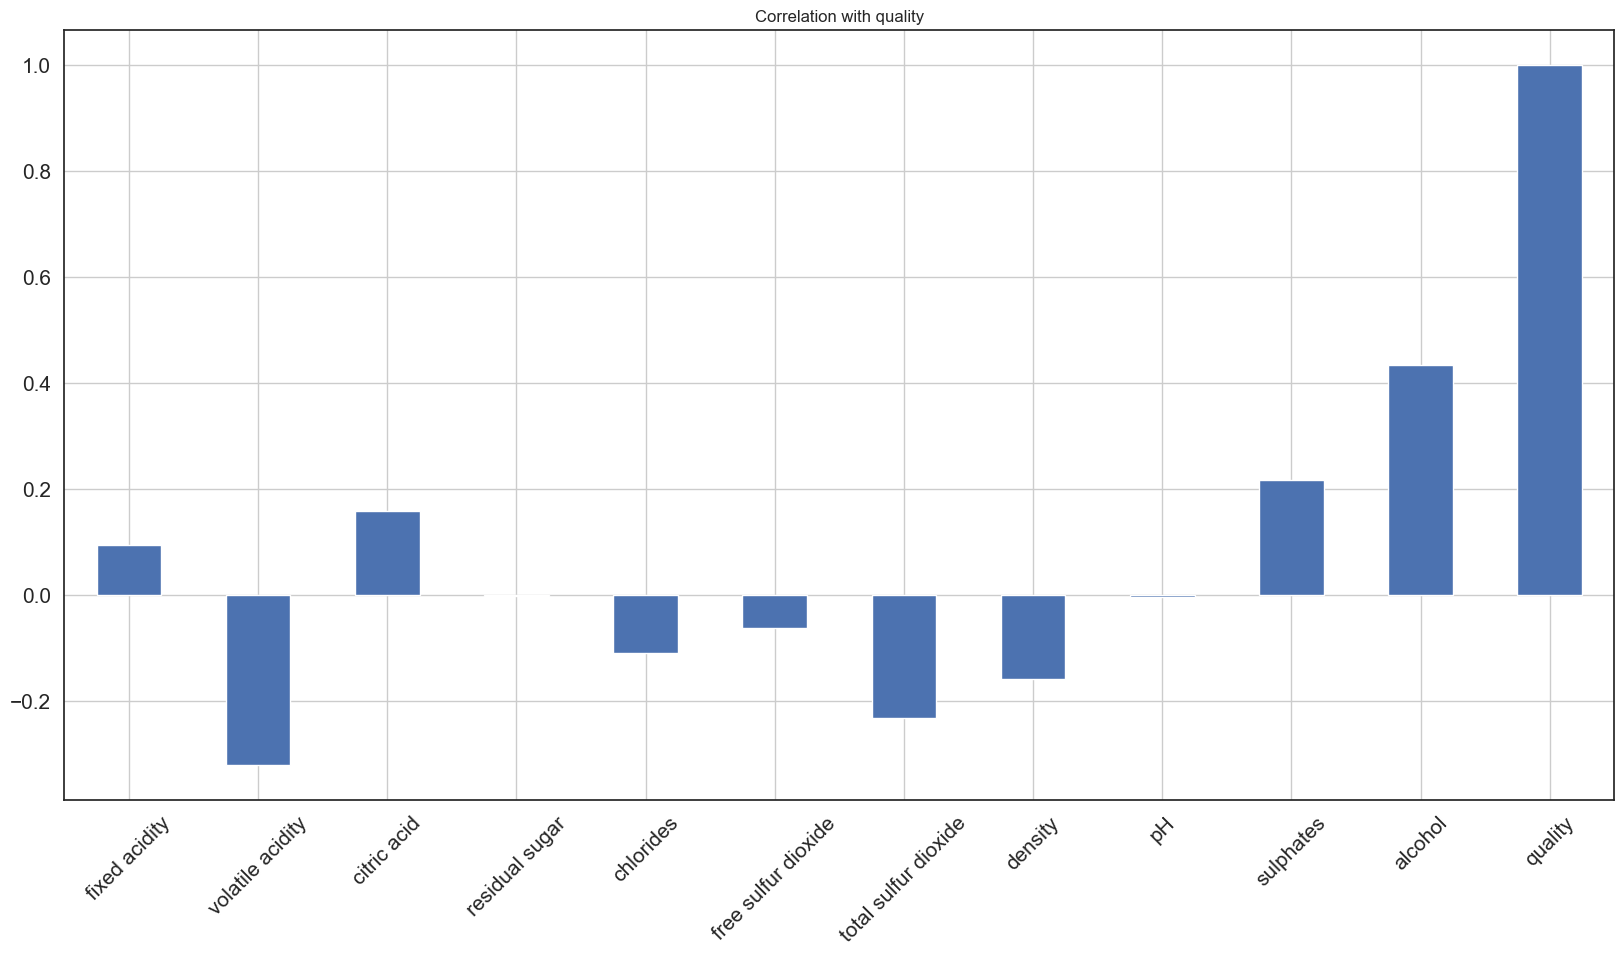

In [39]:
#Correlation with Quality with respect to attributes
df.corrwith(df.quality).plot.bar(
        figsize = (20, 10), title = "Correlation with quality", fontsize = 15,
        rot = 45, grid = True)

In [40]:
## Correlation Matrix
sns.set(style="white")

# Compute the correlation matrix
corr = df.corr()

corr.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
fixed acidity,1.000000,-0.256131,0.671703,0.114777,0.093705,-0.153794,-0.113181,0.668047,-0.682978,0.183006,-0.061668,0.095093
volatile acidity,-0.256131,1.000000,-0.552496,0.001918,0.061298,-0.010504,0.076470,0.022026,0.234937,-0.260987,-0.202288,-0.321441
citric acid,0.671703,-0.552496,1.000000,0.143577,0.203823,-0.060978,0.035533,0.364947,-0.541904,0.312770,0.109903,0.159129
residual sugar,0.114777,0.001918,0.143577,1.000000,0.055610,0.187049,0.203028,0.355283,-0.085652,0.005527,0.042075,-0.002160
chlorides,0.093705,0.061298,0.203823,0.055610,1.000000,0.005562,0.047400,0.200632,-0.265026,0.371260,-0.221141,-0.109494


In [41]:
# Split the data into features and target
X = df.drop('quality', axis=1)
y = df['quality']

# Split the data into training, validation, and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [42]:
# Train a Random Forest model to identify important features
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [43]:
# Evaluate the model's performance on the testing set
y_pred = rf.predict(X_test)
accuracy = rf.score(X_test, y_test)  #we can use the regular classififer method which is accuracy or the cross-entropy loss which is in the next box, choose one.
print("Accuracy: {:.2f}%".format(accuracy*100))

Accuracy: 79.38%


In [44]:
# calculate the cross-entropy loss on the validation set
from sklearn.metrics import log_loss
loss = log_loss(y_val, rf.predict_proba(X_val))

print("Validation Loss: {:.4f}".format(loss))

Validation Loss: 0.4609


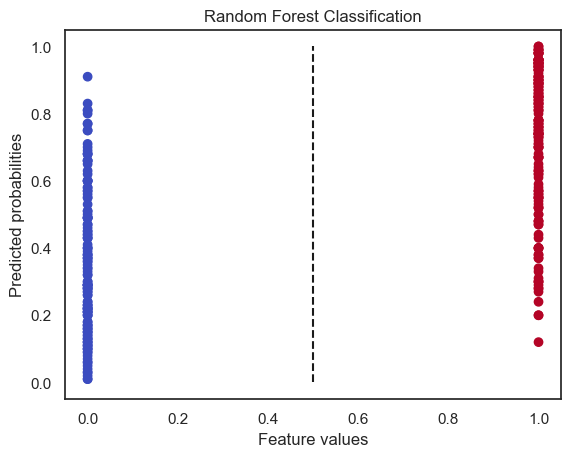

In [45]:
#Plotting classification classes using binary target column

y_test_prob = rf.predict_proba(X_test)[:, 1]
# Create a scatter plot of the predicted probabilities against the Feature values
plt.scatter(y_test, y_test_prob, c=y_test, cmap='coolwarm')

# Draw a line at probability 0.5 to separate the two classes
plt.plot([0.5, 0.5], [0, 1], 'k--')

plt.xlabel('Feature values')
plt.ylabel('Predicted probabilities')
plt.title('Random Forest Classification')
plt.show()

In [46]:
# Print feature importance
importances = pd.Series(rf.feature_importances_, index=X_train.columns)
print(importances.sort_values(ascending=False))

alcohol                 0.182862
sulphates               0.129890
volatile acidity        0.109879
total sulfur dioxide    0.108568
density                 0.094580
fixed acidity           0.069970
chlorides               0.068476
pH                      0.062107
citric acid             0.059464
free sulfur dioxide     0.059198
residual sugar          0.055006
dtype: float64


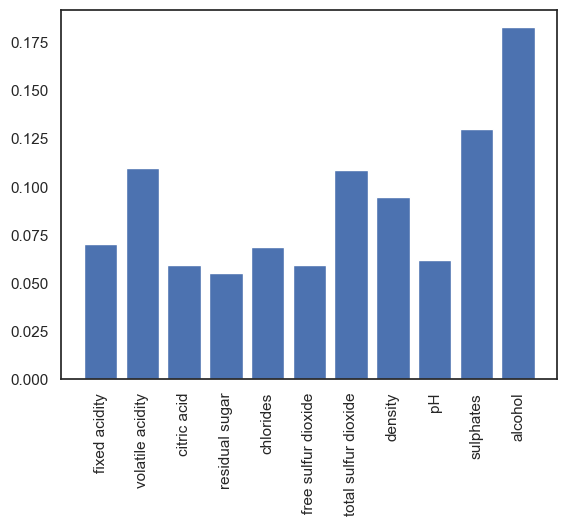

In [50]:
import matplotlib.pyplot as plt

feature_importances = rf.feature_importances_
feature_names = X_train.columns

plt.bar(feature_names, feature_importances)
plt.xticks(rotation=90)
plt.show()

#the sum should be= 1 but ot's = 0.7/////////

In [47]:
# Train a Random Forest model using the important features
important_features = importances[importances > 0.05].index
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train[important_features], y_train)

RandomForestClassifier(random_state=42)

In [48]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 5, 10],
    'max_features': ['auto', 'sqrt']
}

# Perform grid search using the validation set
grid_search = GridSearchCV(rf, param_grid=param_grid, cv=5)
grid_search.fit(X_val[important_features], y_val)

# Get the best model from the grid search
best_rf = grid_search.best_estimator_

print(best_rf)

RandomForestClassifier(random_state=42)


In [49]:
from lime.lime_tabular import LimeTabularExplainer

# Select features for explanation using LIME
explainer = LimeTabularExplainer(X_train.values, feature_names=X_train.columns, class_names=['Bad', 'Good'], 
                                 categorical_features=[0])
                                 

instance = X_test.iloc[0]

# Explain a prediction using LIME
exp = explainer.explain_instance(X_test.iloc[0], best_rf.predict_proba, num_features=len(important_features))
exp.show_in_notebook(show_table=True)

# Print the explanation
print(exp.as_list())

[('0.62 < sulphates <= 0.73', 0.07707868844664173), ('9.50 < alcohol <= 10.20', -0.07093109792483582), ('chlorides > 0.09', -0.06939533037602416), ('fixed acidity=7', 0.048415367623148645), ('7.00 < free sulfur dioxide <= 14.00', -0.03901452198303159), ('38.00 < total sulfur dioxide <= 63.00', 0.028601780092554922), ('3.21 < pH <= 3.31', -0.019875119347753305), ('0.52 < volatile acidity <= 0.63', -0.015423438265849644), ('citric acid <= 0.10', 0.008629676319212385), ('2.20 < residual sugar <= 2.60', -0.006007514623841003), ('1.00 < density <= 1.00', -0.00544737073597946)]


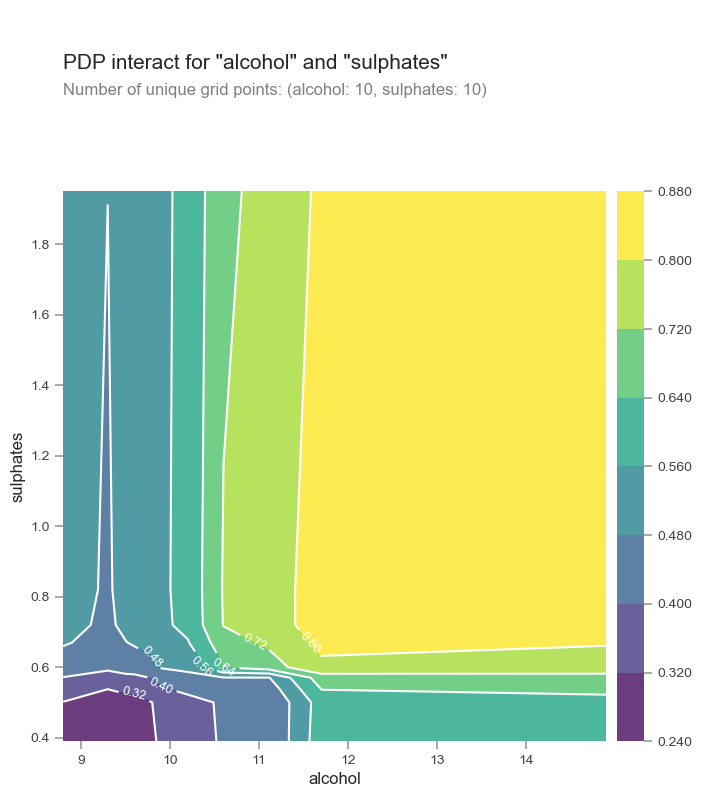

In [51]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features_to_plot = ['alcohol', 'sulphates']

interactions = pdp_interact(
    model=rf,
    dataset=X_val,
    model_features=X_val.columns,
    features=features_to_plot
)

pdp_interact_plot(interactions, features_to_plot)
plt.show()